# basketball team selection

# getting the data ready

In [2]:
import pandas as pd
import numpy as np

#creating a dataframe and filling it with random numbers
df1 = pd.DataFrame(np.random.randint(0,100,size=(300, 3)), columns=list('HWS'))

In [3]:
df1

,H,W,S
0,37,14,61
1,98,61,76
2,95,74,45
3,17,59,71
4,54,86,78
...,...,...,...
295,82,83,54
296,66,4,8
297,77,99,2
298,76,52,80


In [4]:
#renaming columns
df1.rename(columns={'H':'Height'}, inplace=True)
df1.rename(columns={'W':'Weight'}, inplace=True)
df1.rename(columns={'S':'Selection'}, inplace=True)

In [10]:
#filling the weight col with random ints from 49 to 95
df1['Weight'] = np.where(df1['Weight'], 
                       np.random.randint(49, 95, size=300), 
                       df1['Weight'])
#filling the height col with random ints from 149 to 195
df1['Height'] = np.where(df1['Height'], 
                       np.random.randint(149, 195, size=300), 
                       df1['Weight'])

In [18]:
#filling the Selection col with 0 following the conditions
df1.loc[((df1['Weight'] < 56) & (df1['Height'] < 168)) | (df1['Height']-df1['Weight'] < 110), "Selection"] = 0

In [19]:
df1.loc[((df1['Weight'] >= 56) & (df1['Height'] >= 168)) | (df1['Height']-df1['Weight'] >= 110), "Selection"] = 1

In [21]:
df1.Selection.unique()

array([0, 1])

In [23]:
df1.describe()

,Height,Weight,Selection
count,300.000000,300.000000,300.000000
mean,171.363333,72.556667,0.636667
std,12.928333,13.368965,0.481763
min,149.000000,49.000000,0.000000
25%,160.750000,61.000000,0.000000
50%,172.000000,73.000000,1.000000
75%,183.000000,84.000000,1.000000
max,194.000000,94.000000,1.000000


In [24]:
df1.to_csv("teamselectionTrain.csv", index = False)

In [25]:
#create a second dataframe for the testing 

df2 = pd.DataFrame(np.random.randint(0,100,size=(75, 2)), columns=list('HW'))

df2.rename(columns={'H':'Height'}, inplace=True)
df2.rename(columns={'W':'Weight'}, inplace=True)

df2['Weight'] = np.where(df2['Weight'], 
                       np.random.randint(49, 95, size=75), 
                       df2['Weight'])

df2['Height'] = np.where(df2['Height'], 
                       np.random.randint(149, 195, size=75), 
                       df2['Weight'])

In [26]:
df2.to_csv("teamselectionTest.csv", index = False)

## classification

In [27]:
dataset_Train = pd.read_csv("teamselectionTrain.csv")
dataset_Test = pd.read_csv("teamselectionTest.csv")

In [28]:
# We're using all four measurements as inputs
# Note that scikit-learn expects each entry to be a list of values, e.g.,
# [ [val1, val2, val3],
#   [val1, val2, val3],
#   ... ]
# such that our input data set is represented as a list of lists

# We can extract the data in this format from pandas like this:
all_inputs = dataset_Train[['Height', 'Weight']].values

# Similarly, we can extract the class labels
all_labels = dataset_Train['Selection'].values

# Make sure that you don't mix up the order of the entries
# all_inputs[5] inputs should correspond to the class in all_labels[5]

# Here's what a subset of our inputs looks like:
all_inputs[:5]

array([[156,  66],
       [150,  88],
       [165,  64],
       [173,  83],
       [160,  50]], dtype=int64)

In [29]:
#splitting our dataset into test and train
from sklearn.model_selection import train_test_split

(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.2, random_state=1)

we're going to test a few models and see which one renders the best results

decision tree

In [30]:
from sklearn.tree import DecisionTreeClassifier

# Create the classifier
decision_tree_classifier = DecisionTreeClassifier()

# Train the classifier on the training set
decision_tree_classifier.fit(training_inputs, training_classes)

# Validate the classifier on the testing set using classification accuracy
decision_tree_classifier.score(testing_inputs, testing_classes)

1.0

''

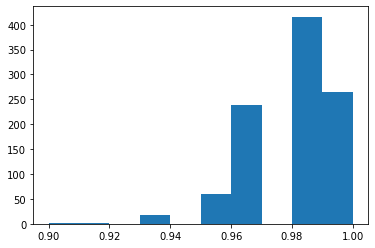

In [32]:
import matplotlib.pyplot as plt
model_accuracies = []
decision_tree_classifier = DecisionTreeClassifier()

for repetition in range(1000):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.2)
    
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_accuracies.append(classifier_accuracy)
    
plt.hist(model_accuracies)
;

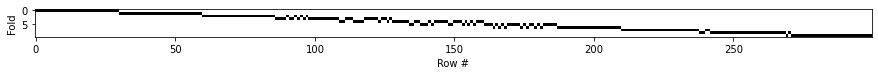

In [33]:
#cross validation

import numpy as np
from sklearn.model_selection import StratifiedKFold

def plot_cv(cv, features, labels):
    masks = []
    for train, test in cv.split(features, labels):
        mask = np.zeros(len(labels), dtype=bool)
        mask[test] = 1
        masks.append(mask)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(masks, interpolation='none', cmap='gray_r')
    plt.ylabel('Fold')
    plt.xlabel('Row #')

plot_cv(StratifiedKFold(n_splits=10), all_inputs, all_labels)

''

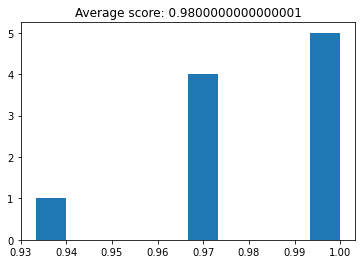

In [34]:
from sklearn.model_selection import cross_val_score

decision_tree_classifier = DecisionTreeClassifier()

# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
;

''

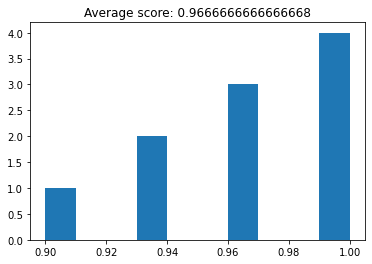

In [35]:
#parameters tuning

decision_tree_classifier = DecisionTreeClassifier(max_depth=1)

cv_scores = cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
;

In [36]:
from sklearn.model_selection import GridSearchCV

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'max_depth': [1, 2, 3],
                  'max_features': [1, 2]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.9866666666666667
Best parameters: {'max_depth': 3, 'max_features': 2}


''

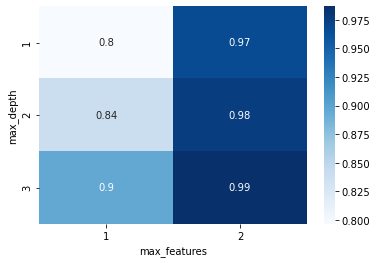

In [38]:
import seaborn as sb
grid_visualization = grid_search.cv_results_['mean_test_score']
grid_visualization.shape = (3, 2)
sb.heatmap(grid_visualization, cmap='Blues', annot=True)
plt.xticks(np.arange(2) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(3) + 0.5, grid_search.param_grid['max_depth'])
plt.xlabel('max_features')
plt.ylabel('max_depth')
;

In [39]:
decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3],
                  'max_features': [1, 2]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.9866666666666667
Best parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 2, 'splitter': 'best'}


In [40]:
decision_tree_classifier = grid_search.best_estimator_
decision_tree_classifier

DecisionTreeClassifier(max_depth=3, max_features=2)

In [41]:
import pickle
pickle.dump(decision_tree_classifier, open("decision_tree_model.pkl",'wb'))

random forest

In [42]:
from sklearn.ensemble import RandomForestClassifier #adaboost xgboost

random_forest_classifier = RandomForestClassifier()

parameter_grid = {'n_estimators': [10, 25, 50, 100],
                  'criterion': ['gini', 'entropy'],
                  'max_features': [1, 2]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(random_forest_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best score: 0.99
Best parameters: {'criterion': 'gini', 'max_features': 1, 'n_estimators': 25}


RandomForestClassifier(max_features=1, n_estimators=25)

''

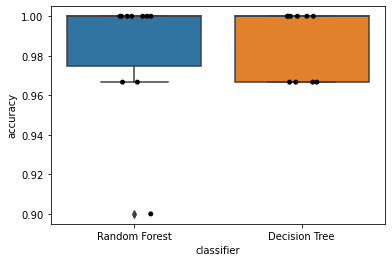

In [43]:
random_forest_classifier = grid_search.best_estimator_

rf_df = pd.DataFrame({'accuracy': cross_val_score(random_forest_classifier, all_inputs, all_labels, cv=10),
                       'classifier': ['Random Forest'] * 10})
dt_df = pd.DataFrame({'accuracy': cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=10),
                      'classifier': ['Decision Tree'] * 10})
both_df = rf_df.append(dt_df)

sb.boxplot(x='classifier', y='accuracy', data=both_df)
sb.stripplot(x='classifier', y='accuracy', data=both_df, jitter=True, color='black')
;

knn

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(training_inputs, training_classes)
y_pred = knn.predict(testing_inputs)
print(metrics.accuracy_score(testing_classes, y_pred))

0.9666666666666667


In [45]:
# try K=1 through K=25 and record testing accuracy
k_range = range(1, 26)

# We can create Python dictionary using [] or dict()
scores = []

# We use a loop through the range 1 to 26
# We append the scores in the dictionary
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(training_inputs, training_classes)
    y_pred = knn.predict(testing_inputs)
    scores.append(metrics.accuracy_score(testing_classes, y_pred))

print(scores)

[0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9833333333333333, 0.9833333333333333, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.95, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9833333333333333, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.95, 0.95, 0.95, 0.9666666666666667, 0.9666666666666667]


Text(0, 0.5, 'Testing Accuracy')

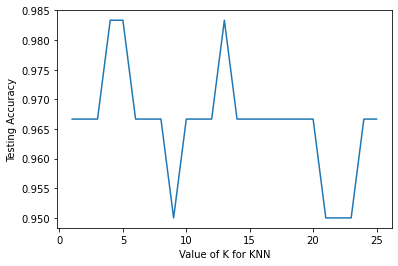

In [46]:
# import Matplotlib (scientific plotting library)
import matplotlib.pyplot as plt

# allow plots to appear within the notebook
%matplotlib inline

# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [47]:
from sklearn.neighbors import KNeighborsClassifier
k_neighors_classifier = KNeighborsClassifier()

parameter_grid = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31],
                  'weights': ['uniform', 'distance'],
                  'metric': ['euclidean', 'manhattan']}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(k_neighors_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           n_jobs=-1)

grid_search.fit(all_inputs, all_labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best score: 0.9866666666666667
Best parameters: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'uniform'}


KNeighborsClassifier(metric='euclidean', n_neighbors=4)

[184  88]	-->	1	(Actual: 1)
[190  94]	-->	1	(Actual: 1)
[149  86]	-->	0	(Actual: 0)
[170  80]	-->	1	(Actual: 1)
[153  61]	-->	0	(Actual: 0)
[181  81]	-->	1	(Actual: 1)
[185  88]	-->	1	(Actual: 1)
[155  68]	-->	0	(Actual: 0)
[192  93]	-->	1	(Actual: 1)
[190  60]	-->	1	(Actual: 1)


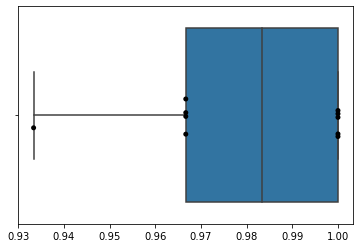

In [48]:
%matplotlib inline
import pandas as pd
import seaborn as sb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

# We can jump directly to working with the clean data because we saved our cleaned data set
data_clean = pd.read_csv('teamselectionTrain.csv')



all_inputs = data_clean[['Height', 'Weight']].values

all_labels = data_clean['Selection'].values

# This is the classifier that came out of Grid Search
random_forest_classifier = RandomForestClassifier(criterion='gini', max_features=2, n_estimators=50)

# All that's left to do now is plot the cross-validation scores
rf_classifier_scores = cross_val_score(random_forest_classifier, all_inputs, all_labels, cv=10)
sb.boxplot(rf_classifier_scores)
sb.stripplot(rf_classifier_scores, jitter=True, color='black')

# ...and show some of the predictions from the classifier
(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.2)

random_forest_classifier.fit(training_inputs, training_classes)

for input_features, prediction, actual in zip(testing_inputs[:10],
                                              random_forest_classifier.predict(testing_inputs[:10]),
                                              testing_classes[:10]):
    print('{}\t-->\t{}\t(Actual: {})'.format(input_features, prediction, actual))

[176  75]	-->	1	(Actual: 1)
[164  79]	-->	0	(Actual: 0)
[170  65]	-->	1	(Actual: 1)
[186  58]	-->	1	(Actual: 1)
[191  89]	-->	1	(Actual: 1)
[169  55]	-->	1	(Actual: 1)
[178  77]	-->	1	(Actual: 1)
[160  66]	-->	0	(Actual: 0)
[187  81]	-->	1	(Actual: 1)
[180  82]	-->	1	(Actual: 1)


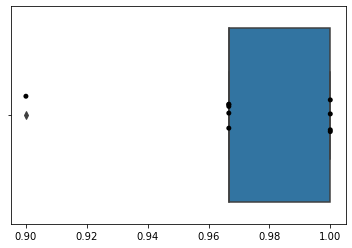

In [49]:
%matplotlib inline
import pandas as pd
import seaborn as sb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score

# We can jump directly to working with the clean data because we saved our cleaned data set
data_clean = pd.read_csv('teamselectionTrain.csv')



all_inputs = data_clean[['Height', 'Weight']].values

all_labels = data_clean['Selection'].values

# This is the classifier that came out of Grid Search
k_neighors_classifier = KNeighborsClassifier(metric='euclidean', n_neighbors=28, weights= 'distance')

# All that's left to do now is plot the cross-validation scores
knn_classifier_scores = cross_val_score(k_neighors_classifier, all_inputs, all_labels, cv=10)
sb.boxplot(knn_classifier_scores)
sb.stripplot(knn_classifier_scores, jitter=True, color='black')

# ...and show some of the predictions from the classifier
(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.2)

k_neighors_classifier.fit(training_inputs, training_classes)

for input_features, prediction, actual in zip(testing_inputs[:10],
                                              k_neighors_classifier.predict(testing_inputs[:10]),
                                              testing_classes[:10]):
    print('{}\t-->\t{}\t(Actual: {})'.format(input_features, prediction, actual))

In [50]:
import pickle
pickle.dump(k_neighors_classifier, open("knn_model.pkl",'wb'))

# song recommendation system

for this recommendation system i used an online tool to download a spotify playlist of mine in csv form (https://rawgit.com/watsonbox/exportify/master/exportify.html)

In [51]:
import pandas as pd
from rake_nltk import Rake
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

#pd.set_option('display.max_columns', 100)
df = pd.read_csv('songs_i_rarely_ever_skip.csv')
df.head()

,﻿Spotify URI,Track Name,Artist Name,Album Name,Disc Number,Track Number,Track Duration (ms),Added By,Added At
0,spotify:track:4u7EnebtmKWzUH433cf5Qv,Bohemian Rhapsody - 2011 Mix,Queen,A Night At The Opera (2011 Remaster),1,11,354320,spotify:user:12169871666,2020-02-17T19:10:59Z
1,spotify:track:2D4BSm5Z8Hq5zYbSgJwEOh,She Used To Be Mine,Sara Bareilles,What's Inside: Songs from Waitress,1,10,250266,spotify:user:12169871666,2020-02-17T19:11:22Z
2,spotify:track:1CGQTaQVVfA0CNae8IwPyC,Bad as the Boys (feat. ALMA),"Tove Lo, ALMA",Sunshine Kitty,1,3,186555,spotify:user:12169871666,2020-02-17T19:11:51Z
3,spotify:track:1SFDYObi6lB3MpiIkWTXla,Opium,The New Division,Shadows,1,1,320022,spotify:user:12169871666,2020-02-17T19:12:18Z
4,spotify:track:2k6oLQC0nAw99WL1euDWdG,PAPI,Isabela Merced,PAPI,1,1,150266,spotify:user:12169871666,2020-02-17T19:12:23Z


In [52]:
df.shape

(169, 9)

In [53]:
#choosing the colmuns i want to base my recommendation upon
df = df[['Artist Name','Track Name','Album Name']]
df.head()

,Artist Name,Track Name,Album Name
0,Queen,Bohemian Rhapsody - 2011 Mix,A Night At The Opera (2011 Remaster)
1,Sara Bareilles,She Used To Be Mine,What's Inside: Songs from Waitress
2,"Tove Lo, ALMA",Bad as the Boys (feat. ALMA),Sunshine Kitty
3,The New Division,Opium,Shadows
4,Isabela Merced,PAPI,PAPI


In [54]:
#renaming the colmuns to avoid errors
df= df.rename(columns={'Artist Name':'artist','Track Name':'track','Album Name':'album'})

In [55]:
df.head()

,artist,track,album
0,Queen,Bohemian Rhapsody - 2011 Mix,A Night At The Opera (2011 Remaster)
1,Sara Bareilles,She Used To Be Mine,What's Inside: Songs from Waitress
2,"Tove Lo, ALMA",Bad as the Boys (feat. ALMA),Sunshine Kitty
3,The New Division,Opium,Shadows
4,Isabela Merced,PAPI,PAPI


In [56]:
#gathering all the titles in one list to later use in our flask api
all_titles = [df['track'][i] for i in range(len(df['track']))]

In [57]:
all_titles

['Bohemian Rhapsody - 2011 Mix',
 'She Used To Be Mine',
 'Bad as the Boys (feat. ALMA)',
 'Opium',
 'PAPI',
 'Primadonna',
 'Raising Hell (feat. Big Freedia)',
 'Season Of The Witch',
 'Teenage Dream',
 'S&M',
 'Toxic',
 'Hard out Here',
 'Sweet but Psycho',
 'I Kissed A Girl',
 'Criminal',
 'Sk8er Boi',
 'Estrangers',
 'Re: Stacks',
 'Feel Good Inc.',
 'Hard Times',
 'Fireflies',
 'A Thousand Miles',
 'Hey There Delilah',
 'Soda Shop',
 'Still into You',
 'Natalie Portman 2002',
 'Crush',
 'Kaitlin',
 "Don't Stop Me Now - 2011 Mix",
 'Take on Me',
 'I Want You to Want Me',
 "I Won't Say (I'm In Love)",
 'Apex Predator',
 "Kiss Me, I'm Shitfaced",
 'Kiss from a Rose',
 'To Build A Home',
 'Ojos Así',
 'Vindicated',
 'Echo Beach',
 'Bubblegum Bitch',
 'We R Who We R',
 "Doin' Time",
 'ROCKSTAR 101',
 'Lost My Mind',
 'Hey, Ma',
 'Skinny Love',
 'Clint Eastwood',
 'Ignorance',
 'Fight For Your Right',
 'Girl on Fire',
 'No Scrubs',
 'Waterfalls',
 'Hey Ya!',
 'Price Tag',
 'Irreplaceabl

transforming the artists names and albums into single words so that they become unique values

In [58]:
# discarding the commas between the artists' full names and getting only the first three names
df['artist'] = df['artist'].map(lambda x: x.split(',')[:3])

# putting the genres in a list of words
df['album'] = df['album'].map(lambda x: x.lower().split(',')[:4])

# merging together first and last name for each singer, so it's considered as one word 
# and there is no mix up between people sharing a first name
for index, row in df.iterrows():
    row['artist'] = [x.lower().replace(' ','') for x in row['artist']]

In [59]:
#setting the column track as the index for the df
df.set_index('track', inplace = True)
df.head()

,artist,album
track,,
Bohemian Rhapsody - 2011 Mix,[queen],[a night at the opera (2011 remaster)]
She Used To Be Mine,[sarabareilles],[what's inside: songs from waitress]
Bad as the Boys (feat. ALMA),"[tovelo, alma]",[sunshine kitty]
Opium,[thenewdivision],[shadows]
PAPI,[isabelamerced],[papi]


In [60]:
df['bag_of_words'] = ''
columns = df.columns
for index, row in df.iterrows():
    words = ''
    for col in columns:
            words = words + ' '.join(row[col])+ ' '
    row['bag_of_words'] = words
    
df.drop(columns = [col for col in df.columns if col!= 'bag_of_words'], inplace = True)

In [61]:
df.head()

,bag_of_words
track,
Bohemian Rhapsody - 2011 Mix,queen a night at the opera (2011 remaster)
She Used To Be Mine,sarabareilles what's inside: songs from waitre...
Bad as the Boys (feat. ALMA),tovelo alma sunshine kitty
Opium,thenewdivision shadows
PAPI,isabelamerced papi


In [62]:
# instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(df['bag_of_words'])

# creating a Series for the song titles so they are associated to an ordered numerical
# list I will use later to match the indexes
indices = pd.Series(df.index)
indices[:3]

0    Bohemian Rhapsody - 2011 Mix
1             She Used To Be Mine
2    Bad as the Boys (feat. ALMA)
Name: track, dtype: object

In [63]:
# generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [64]:
# function that takes in song title as input and returns the top 10 recommended songs
def recommendations(title, cosine_sim = cosine_sim):
    
    recommended_songs = []
    
    # gettin the index of the song that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar songs
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching songs
    for i in top_10_indexes:
        recommended_songs.append(list(df.index)[i])
        
    return recommended_songs

In [65]:
recommendations('Toxic')

['Irreplaceable',
 'Criminal',
 'Till the World Ends',
 'I Wanna Go',
 'She Used To Be Mine',
 "Kiss Me, I'm Shitfaced",
 'Got My Mind Set On You - 2009 Mix',
 'In Waves',
 'Carried Away',
 'Before He Cheats']

In [66]:
import pickle
pickle.dump(recommendations, open("r_model.pkl",'wb'))

In [ ]:
import pandas as pd
from rake_nltk import Rake
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

#pd.set_option('display.max_columns', 100)
df = pd.read_csv('songs_i_rarely_ever_skip.csv')

df = df[['Artist Name','Track Name','Album Name']]
df= df.rename(columns={'Artist Name':'artist','Track Name':'track','Album Name':'album'})

# discarding the commas between the artists' full names and getting only the first three names
df['artist'] = df['artist'].map(lambda x: x.split(',')[:3])

# putting the album in a list of words
df['album'] = df['album'].map(lambda x: x.lower().split(',')[:4])

# merging together first and last name for each singer, so it's considered as one word 
# and there is no mix up between people sharing a first name
for index, row in df.iterrows():
    row['artist'] = [x.lower().replace(' ','') for x in row['artist']]

df.set_index('track', inplace = True)

df['bag_of_words'] = ''
columns = df.columns
for index, row in df.iterrows():
    words = ''
    for col in columns:
            words = words + ' '.join(row[col])+ ' '
    row['bag_of_words'] = words
    
df.drop(columns = [col for col in df.columns if col!= 'bag_of_words'], inplace = True)

# instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(df['bag_of_words'])

# creating a Series for the song titles so they are associated to an ordered numerical
# list I will use later to match the indexes
indices = pd.Series(df.index)
indices[:3]

# generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)
cosine_sim

# function that takes in song title as input and returns the top 10 recommended songs
def recommendations(title, cosine_sim = cosine_sim):
    
    recommended_songs = []
    
    # gettin the index of the song that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar songs
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching songs
    for i in top_10_indexes:
        recommended_songs.append(list(df.index)[i])
        
    return recommended_songs

recommendations('Toxic')